# Traffic Analysis

A trained YOLOv8n model is used to generate tabular traffic flow data from images captured at two-minute intervals from a live feed. The goal is to develop an anomaly detection system that leverages this tabular traffic flow data.

## Packages

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os 
from ultralytics import YOLO
import cv2

# Importing project packages
from object_detection.generate_time_series import TrafficDataGenerator

## Constants

In [ ]:
SEED=53456
CAMERA = '147'
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# setting up the paths


# data paths
cwd=os.getcwd()
root = os.path.dirname(cwd)
processed_image_dir = os.path.join(root, 'dat','processed_images')
image_folder = os.path.join(processed_image_dir,CAMERA,'2024-12-11')
output_folder = os.path.join(root, 'dat','output')
camera_dir = os.path.join(processed_image_dir, CAMERA)
tabular_csv_path = os.path.join(output_folder, 'traffic_147_two_way.csv')

# model paths
run_dir = os.path.join(root, 'runs','detect')
best_weights_path  = os.path.join(run_dir, 'train15', 'weights','best.pt')

## Functions

In [7]:
def plot_boxes(result, color_map=None):
    if color_map is None:
        color_map = {0: 'red', 1: 'blue'}

    image_rgb = cv2.cvtColor(result.orig_img, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    boxes = result.boxes
    for box, cls, conf in zip(boxes.xywh, boxes.cls, boxes.conf):
        cls = int(cls)
        x_center, y_center, width, height = box
        rect = plt.Rectangle((x_center - width / 2, y_center - height / 2), width, height, fill=True, color=color_map[cls], alpha=0.3)
        plt.gca().add_patch(rect)
        plt.text(x_center, y_center, f'{conf:.2f}', fontsize=5, color='white', verticalalignment='center', horizontalalignment='center')

## Object detection: YOLOv8n

In [5]:
# Load a model
model = YOLO(best_weights_path)  # fine-tuned yolov8n model

### Single image detection 


0: 320x448 5 incomings, 11 outgoings, 154.2ms
Speed: 4.5ms preprocess, 154.2ms inference, 2.0ms postprocess per image at shape (1, 3, 320, 448)


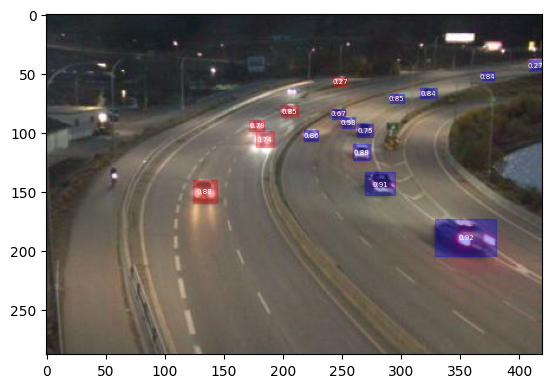

In [6]:
image_file_path = os.path.join(processed_image_dir,CAMERA,'2024-11-15', 'traffic_202411151644.jpg')
image_paths = [image_file_path]
results = model(image_paths)  

plot_boxes(results[0])

### Detect cars from images in a day

In [7]:
image_paths = [os.path.join(image_folder, file) for file in os.listdir(image_folder)]
results = model(image_paths)  


dict_data = dict(incoming=[], outgoing=[])
# Process results list
for result in results:
    boxes = result.boxes  
    dict_temp_count = dict(incoming=0, outgoing=0)
    vals, counts = np.unique(boxes.cls.cpu().numpy(), return_counts=True)
    for val, count in zip(vals, counts):
        dict_temp_count[result.names[val]] = count

    for key, item in dict_temp_count.items():
        dict_data[key].append(item)


0: 320x448 (no detections), 37.5ms
1: 320x448 (no detections), 37.5ms
2: 320x448 (no detections), 37.5ms
3: 320x448 1 incoming, 37.5ms
4: 320x448 1 incoming, 37.5ms
5: 320x448 (no detections), 37.5ms
6: 320x448 1 incoming, 37.5ms
7: 320x448 4 incomings, 1 outgoing, 37.5ms
8: 320x448 1 incoming, 37.5ms
9: 320x448 (no detections), 37.5ms
10: 320x448 2 incomings, 37.5ms
11: 320x448 1 outgoing, 37.5ms
12: 320x448 1 incoming, 37.5ms
13: 320x448 1 outgoing, 37.5ms
14: 320x448 1 incoming, 1 outgoing, 37.5ms
15: 320x448 2 incomings, 37.5ms
16: 320x448 1 outgoing, 37.5ms
17: 320x448 (no detections), 37.5ms
18: 320x448 (no detections), 37.5ms
19: 320x448 (no detections), 37.5ms
20: 320x448 1 incoming, 37.5ms
21: 320x448 (no detections), 37.5ms
22: 320x448 1 outgoing, 37.5ms
23: 320x448 (no detections), 37.5ms
24: 320x448 1 incoming, 37.5ms
25: 320x448 1 incoming, 37.5ms
26: 320x448 1 incoming, 1 outgoing, 37.5ms
27: 320x448 (no detections), 37.5ms
28: 320x448 2 outgoings, 37.5ms
29: 320x448 1 o

### Plot results

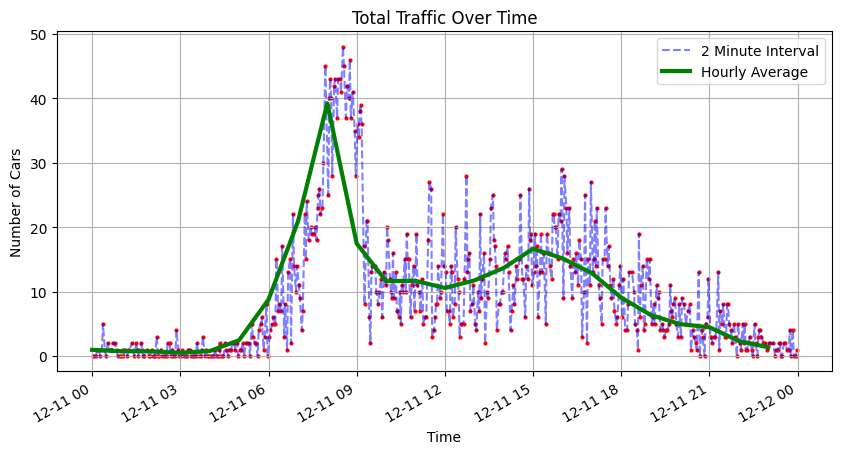

In [8]:
time_stamps = [
    datetime.strptime(string[8:-4], '%Y%m%d%H%M') for string in os.listdir(image_folder)
]

df = pd.DataFrame(dict_data)
df['time'] = time_stamps
df['image_paths'] = image_paths
df['num_cars'] = df['incoming'] + df['outgoing']
df['net'] = df['incoming'] - df['outgoing']

df.set_index('time', inplace=True)
df_hourly = df[['num_cars', 'net']].resample('h').mean().reset_index()


# Plotting the data
plt.figure(figsize=(10, 5))
plt.plot(df.index, df.num_cars, label='2 Minute Interval', color='blue', linestyle='dashed', alpha=0.5)
plt.scatter(df.index, df.num_cars, s=4, color='red')

plt.plot(df_hourly['time'], df_hourly['num_cars'], label='Hourly Average', color='green', lw=3)

# Formatting the x-axis for better readability
plt.gcf().autofmt_xdate()  # Auto formats dates for better display
plt.xlabel('Time')
plt.ylabel('Number of Cars')
plt.title('Total Traffic Over Time')
plt.grid(True)
plt.legend()
plt.show()


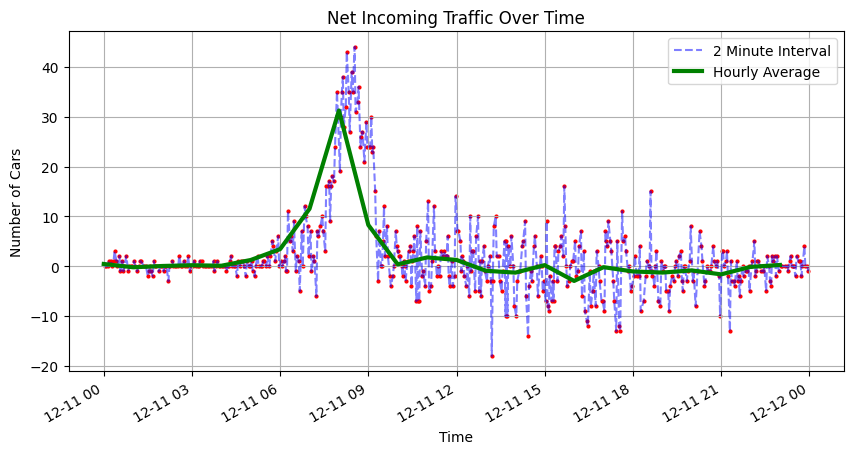

In [9]:
# Plotting the data
plt.figure(figsize=(10, 5))
plt.plot(df.index, df.net, label='2 Minute Interval', color='blue', linestyle='dashed', alpha=0.5)
plt.scatter(df.index, df.net, s=4, color='red')

plt.plot(df_hourly['time'], df_hourly['net'], label='Hourly Average', color='green', lw=3)

# Formatting the x-axis for better readability
plt.gcf().autofmt_xdate()  # Auto formats dates for better display
plt.xlabel('Time')
plt.ylabel('Number of Cars')
plt.title('Net Incoming Traffic Over Time')
plt.grid(True)
plt.legend()
plt.show()


### Generating tabular data from all the available dates

In [ ]:
generate_time_series = TrafficDataGenerator(
    camera_dir=camera_dir,
    best_weights_path=best_weights_path,
    tabular_csv_path=tabular_csv_path,
    overwrite=False
)
generate_time_series.generate_tabular_csv()

## Analyse tabular data

### Loading file

In [39]:
df = pd.read_csv(tabular_csv_path)

### Prepping dataframe

In [53]:
df['net'] = df['incoming'] - df['outgoing']

#group time column by days of the week 
df['day_of_week'] = df['time'].dt.day_name()

#group time column by hours of the day
df['hour_of_day'] = df['time'].dt.hour 

df['time'].min(), df['time'].max()

(Timestamp('2024-10-28 00:02:00'), Timestamp('2024-12-20 17:44:00'))

### Checking data distribution

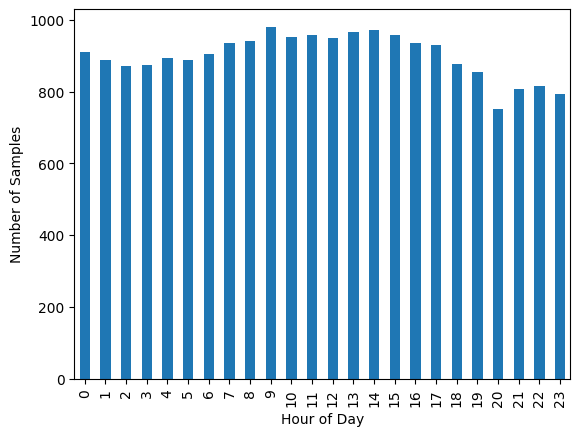

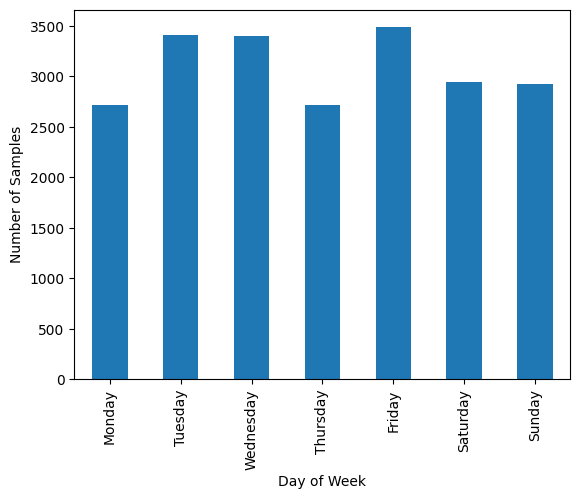

In [47]:
df['hour_of_day'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Samples')
plt.show()

df['day_of_week'].value_counts().loc[days].plot(kind='bar')
plt.xlabel('Day of Week')
plt.ylabel('Number of Samples')
plt.show()

### Inspecting for trends

Interestingly Monday and Friday does not contain the same morning traffic peaks Tuesday, Wednesday, and Thursday. Consider if mean or median is a better summary statistic here. 

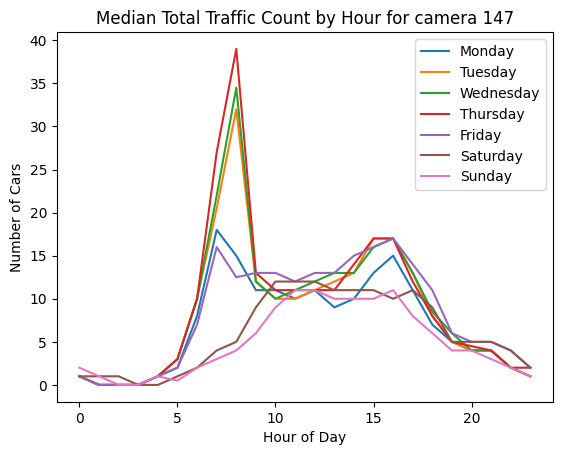

In [58]:
for day in days:
    df_day = df[df['day_of_week'] == day]
    df_day.groupby('hour_of_day')['num_cars'].median().plot(label=day, legend=True)
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Cars')
    plt.title(f'Median Total Traffic Count by Hour for camera {CAMERA}')

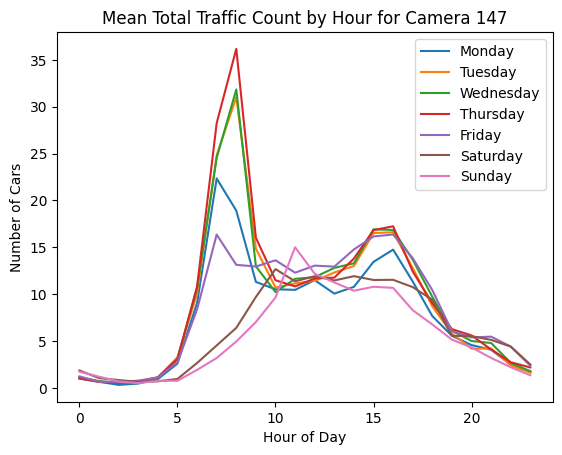

In [57]:
for day in days:
    df_day = df[df['day_of_week'] == day]
    df_day.groupby('hour_of_day')['num_cars'].mean().plot(label=day, legend=True)
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Cars')
    plt.title(f'Mean Total Traffic Count by Hour for Camera {CAMERA}')

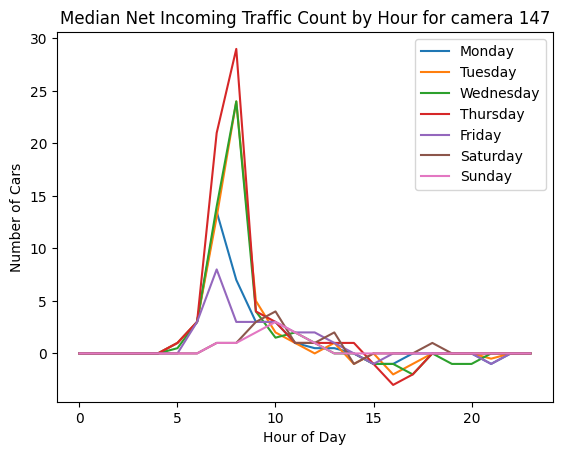

In [56]:
for day in days:
    df_day = df[df['day_of_week'] == day]
    df_day.groupby('hour_of_day')['net'].median().plot(label=day, legend=True)
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Cars')
    plt.title(f'Median Net Incoming Traffic Count by Hour for camera {CAMERA}')